# Modelamiento Anomalias mediante LSTM

CELDA 1-2: Configuración Base  
- Preparan el entorno y definen métricas esenciales  
- RMSE: Para errores en misma escala de los datos  
- MAPE: Para entender error en porcentaje  

CELDA 3: Transformación de Datos  
- Convierte series temporales en formato LSTM (secuencias)  
- Lookback: Cuánto pasado ve el modelo para predecir futuro  

CELDA 4: Motor de Entrenamiento  
- Construye y entrena modelos LSTM individuales  
- Implementa callbacks avanzados para mejor entrenamiento  
- Evalúa con múltiples métricas en train/val/test  

CELDA 5: Visualización  
- Genera gráficas comparativas de los mejores modelos  
- Ayuda a identificar overfitting y convergencia  

CELDA 6: Grid Search Principal  
- Busca sistemáticamente la mejor combinación de hiperparámetros  
- Usa cache para eficiencia y TensorBoard para monitoreo  
- Genera rankings automáticos por calidad del modelo  

CELDA 7-11: Ejecución y Resultados  
- Ejecuta todo el proceso y muestra resultados  
- Proporciona análisis del mejor modelo  
- Da instrucciones para TensorBoard y próximos pasos  

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/gdrive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Leer set de datos
path = '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/'

dTraining_Scaled = pd.read_csv(path+'training_scaled.csv', sep='|', index_col=0)
dValidation_Scaled=pd.read_csv(path+'validation_scaled.csv', sep='|', index_col=0)
dTesting_Scaled = pd.read_csv(path+'testing_scaled.csv', sep='|', index_col=0)

In [ ]:
dTraining_Scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17008 entries, 2025-06-06 00:55:00 to 2025-08-04 02:10:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   num_files_total      17008 non-null  float64
 1   count_moving_mean    17008 non-null  float64
 2   count_moving_std     17008 non-null  float64
 3   files_size_MB_total  17008 non-null  float64
 4   size_moving_mean     17008 non-null  float64
 5   size_moving_std      17008 non-null  float64
dtypes: float64(6)
memory usage: 930.1+ KB


In [ ]:
print(f'Tamaño set de entrenamiento: {dTraining_Scaled.shape}')
print(f'Tamaño set de validación: {dValidation_Scaled.shape}')
print(f'Tamaño set de prueba: {dTesting_Scaled.shape}')

Tamaño set de entrenamiento: (17008, 2)
Tamaño set de validación: (4032, 2)
Tamaño set de prueba: (4032, 2)


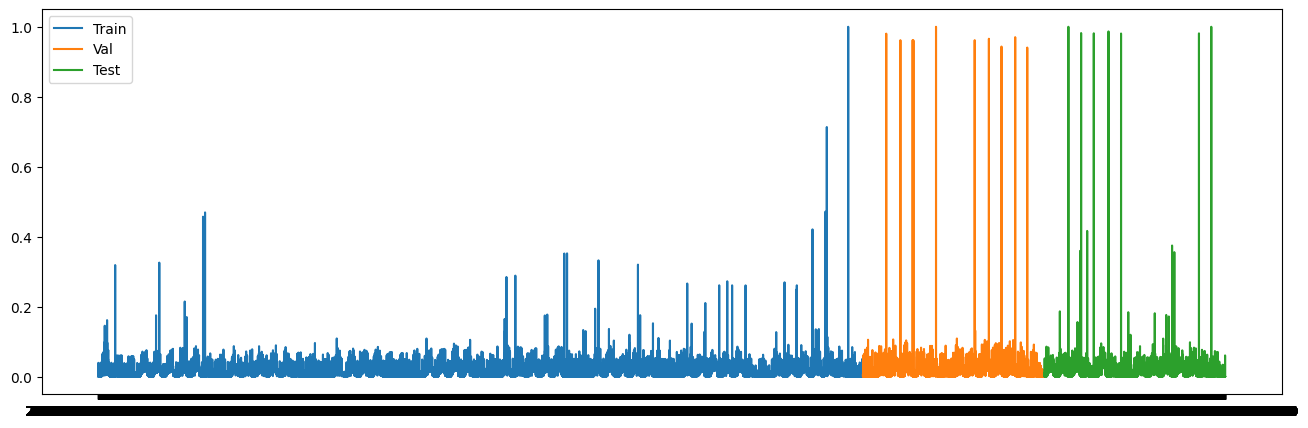

In [ ]:
# Dibujemos los subsets
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(dTraining_Scaled['num_files_total'], label='Train')
ax.plot(dValidation_Scaled['num_files_total'], label='Val')
ax.plot(dTesting_Scaled['num_files_total'], label='Test')
plt.legend();

In [ ]:
# CONFIGURACIÓN INICIAL Y LIBRERÍAS

"""
OBJETIVO: Configurar el entorno y cargar todas las librerías necesarias
EXPLICACIÓN:
- Desactivamos warnings para tener una salida más limpia
- Importamos todas las librerías que usaremos en el proyecto
- Configuramos semillas para reproducibilidad (ESENCIAL en ML)
- Las semillas aseguran que los resultados sean los mismos en cada ejecución
"""

import warnings
warnings.filterwarnings("ignore")  # Limpia la salida de avisos no críticos

# Librerías estándar de Python
import os           # Para manejo de archivos y directorios
import math         # Funciones matemáticas
import random       # Generación de números aleatorios
import itertools    # Para crear combinaciones de parámetros
import numpy as np  # Computación numérica, arrays y matrices
import pandas as pd # Manipulación y análisis de datos
import matplotlib.pyplot as plt  # Visualización de datos
import seaborn as sns            # Visualización estadística
from tqdm import tqdm            # Barras de progreso para bucles

# Métricas de evaluación de modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# CONFIGURACIÓN DE REPRODUCIBILIDAD - CRÍTICO PARA RESULTADOS CONSISTENTES
SEED = 42
np.random.seed(SEED)  # Semilla para NumPy
random.seed(SEED)     # Semilla para Python random

print("Configuración inicial completada - Entorno listo para ML")

Configuración inicial completada - Entorno listo para ML


In [ ]:
# MÉTRICAS ADICIONALES


"""
OBJETIVO: Crear funciones de métricas de evaluación personalizadas
EXPLICACIÓN:
- RMSE: Raíz del error cuadrático medio - penaliza errores grandes
- MAPE: Error porcentual absoluto medio - fácil interpretación en %
- Ambas son esenciales para evaluar modelos de series temporales
"""

def rmse(y_true, y_pred):
    """
    Calcula la Raíz del Error Cuadrático Medio (Root Mean Squared Error)
    Útil porque está en las mismas unidades que la variable original
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    """
    Calcula el Error Porcentual Absoluto Medio (Mean Absolute Percentage Error)
    Mide el error promedio en porcentaje - muy interpretable
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # PROTECCIÓN CONTRA DIVISIÓN POR CERO: usamos 1e-8 cuando y_true es 0
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred)/denom)) * 100

print("Metricas personalizadas definidas - RMSE y MAPE listos")

Metricas personalizadas definidas - RMSE y MAPE listos


In [ ]:
# FUNCIÓN PARA CREAR SECUENCIAS LOOKBACK

"""
OBJETIVO: Transformar series temporales en formato supervisado para LSTM
EXPLICACIÓN:
- Las LSTM necesitan secuencias de datos pasados para predecir el futuro
- Lookback: cuántos pasos anteriores usa el modelo para predecir el siguiente
- Ejemplo: con lookback=48, usamos 48 puntos para predecir el punto 49
- Esto convierte el problema en uno de aprendizaje supervisado
"""

def create_lookback(dataset, lookback, target_col):
    """
    Convierte una serie temporal en un dataset supervisado para LSTM

    Args:
        dataset: DataFrame de pandas con la serie temporal
        lookback: número de timesteps anteriores a usar para la predicción
        target_col: nombre de la columna que queremos predecir

    Returns:
        X: array 3D de forma (muestras, lookback, características) para LSTM
        y: array 1D con los valores objetivo a predecir
    """
    X, y = [], []
    # Encontramos el índice de la columna objetivo
    target_idx = dataset.columns.get_loc(target_col)

    # CREAMOS VENTANAS DESLIZANTES
    for i in range(len(dataset) - lookback):
        # X: secuencia de 'lookback' timesteps con TODAS las características
        X.append(dataset.iloc[i:i+lookback].values)
        # y: valor siguiente de la columna objetivo
        y.append(dataset.iloc[i+lookback, target_idx])

    return np.array(X), np.array(y)

print("Funcion de lookback creada - Series convertidas a formato LSTM")

Funcion de lookback creada - Series convertidas a formato LSTM


In [ ]:
#  FUNCIÓN DE ENTRENAMIENTO

"""
OBJETIVO: Entrenar y evaluar un modelo LSTM individual con callbacks avanzados
EXPLICACIÓN:
- Crea y entrena un modelo LSTM con arquitectura configurable
- Implementa callbacks para mejorar entrenamiento: Early Stopping, ReduceLROnPlateau
- Incluye TensorBoard para monitoreo visual del entrenamiento
- Evalúa el modelo en train/val/test con múltiples métricas
"""

def _train_and_eval_model_enhanced(params, X_train, y_train, X_val, y_val, X_test, y_test,
                          epochs, patience, reduce_lr_patience, model_dir_prefix, tensorboard_cb):
    """
    Función interna que entrena un modelo LSTM con configuración específica

    Args:
        params: diccionario con hiperparámetros del modelo
        X_train, y_train: datos de entrenamiento
        X_val, y_val: datos de validación para early stopping
        X_test, y_test: datos de test para evaluación final
        epochs: máximo número de épocas de entrenamiento
        patience: paciencia para early stopping
        reduce_lr_patience: paciencia para reducir learning rate
        model_dir_prefix: directorio donde guardar modelos
        tensorboard_cb: callback de TensorBoard para monitoreo

    Returns:
        result: diccionario con parámetros, métricas e información del entrenamiento
    """

    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam

    # REPRODUCIBILIDAD EN TENSORFLOW
    tf.keras.utils.set_random_seed(SEED)

    # CONSTRUCCIÓN DEL MODELO LSTM
    layers = params["layers"]          # Número de capas LSTM (1 o 2)
    neurons = params["neurons"]        # Neuronas por capa (16, 32, 64)
    activation = params["activation"]  # Función de activación (relu, sigmoid)
    lr = params["learning_rate"]       # Tasa de aprendizaje
    dropout = params["dropout"]        # Tasa de dropout para regularización
    batch = params["batch"]            # Tamaño del batch
    lookback = params["lookback"]      # Ventana temporal

    # La forma de entrada es (lookback, número_de_características)
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = Sequential()

    # ARQUITECTURA CONFIGURABLE
    if layers == 1:
        # Modelo con UNA sola capa LSTM
        model.add(LSTM(neurons, activation=activation, return_sequences=False,
                       input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))  # Dropout para prevenir overfitting
    else:
        # Modelo con DOS capas LSTM
        # Primera capa: return_sequences=True para conectar con siguiente LSTM
        model.add(LSTM(neurons, activation=activation, return_sequences=True,
                       input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))
        # Segunda capa: return_sequences=False (última capa LSTM)
        model.add(LSTM(neurons, activation=activation, return_sequences=False))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Capa de salida: 1 neurona (regresión)
    model.add(Dense(1))
    # Compilación con optimizador Adam y función de pérdida MSE
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

    # CALLBACKS AVANZADOS
    # Nombre del archivo que identifica el modelo por sus parámetros
    filename = os.path.join(model_dir_prefix,
                           f"model_L{layers}N{neurons}A{activation}LB{lookback}LR{lr}D{dropout}B{batch}.keras")

    # EARLY STOPPING: Detiene entrenamiento si no mejora en 'patience' épocas
    es = EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True, verbose=0)

    # REDUCE LEARNING RATE: Reduce LR si no hay mejora
    rlr = ReduceLROnPlateau(monitor="val_loss", patience=reduce_lr_patience, factor=0.5, verbose=0)

    # MODEL CHECKPOINT: Guarda el mejor modelo durante entrenamiento
    mc = ModelCheckpoint(filename, monitor="val_loss", save_best_only=True, verbose=0)

    # Lista de todos los callbacks (incluyendo TensorBoard)
    callbacks = [es, rlr, mc, tensorboard_cb]

    # ENTRENAMIENTO DEL MODELO
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # Datos para validación y early stopping
        epochs=epochs,                   # Máximo número de épocas
        batch_size=batch,                # Tamaño del batch
        verbose=0,                       # 0 = sin output, 1 = con progreso
        callbacks=callbacks              # Callbacks aplicados
    )

    # CARGAR MEJORES PESOS (los guardados por ModelCheckpoint)
    model.load_weights(filename)

    # EVALUACIÓN Y PREDICCIONES
    # Generar predicciones en todos los conjuntos
    y_train_pred = model.predict(X_train, verbose=0).ravel()
    y_val_pred = model.predict(X_val, verbose=0).ravel()
    y_test_pred = model.predict(X_test, verbose=0).ravel()

    # CÁLCULO EXHAUSTIVO DE MÉTRICAS
    result = dict(params)  # Copiamos los parámetros

    metrics = {
        # Mean Squared Error (Error Cuadrático Medio)
        "train_mse": mean_squared_error(y_train, y_train_pred),
        "val_mse": mean_squared_error(y_val, y_val_pred),
        "test_mse": mean_squared_error(y_test, y_test_pred),

        # Mean Absolute Error (Error Absoluto Medio)
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "val_mae": mean_absolute_error(y_val, y_val_pred),
        "test_mae": mean_absolute_error(y_test, y_test_pred),

        # Root Mean Squared Error (Raíz del Error Cuadrático Medio)
        "train_rmse": rmse(y_train, y_train_pred),
        "val_rmse": rmse(y_val, y_val_pred),
        "test_rmse": rmse(y_test, y_test_pred),

        # Mean Absolute Percentage Error (Error Porcentual Absoluto Medio)
        "train_mape": mape(y_train, y_train_pred),
        "val_mape": mape(y_val, y_val_pred),
        "test_mape": mape(y_test, y_test_pred),

        # R² Score (Coeficiente de determinación)
        "train_r2": r2_score(y_train, y_train_pred),
        "val_r2": r2_score(y_val, y_val_pred),
        "test_r2": r2_score(y_test, y_test_pred),

        # Información del entrenamiento
        "epochs_trained": len(history.history['loss']),  # Épocas realmente usadas
        "final_learning_rate": history.history['lr'][-1] if 'lr' in history.history else lr,
        "final_train_loss": history.history['loss'][-1],
        "final_val_loss": history.history['val_loss'][-1],

        # Información adicional del modelo
        "model_id": f"L{layers}N{neurons}A{activation}LB{lookback}LR{lr}D{dropout}B{batch}",
        "total_parameters": model.count_params()
    }

    # Combinamos parámetros con métricas
    result.update(metrics)
    result["model_path"] = filename    # Ruta del modelo guardado
    result["history"] = history.history # Historial completo de entrenamiento

    return result

print("Funcion de entrenamiento mejorada creada - LSTM + TensorBoard listos")

Funcion de entrenamiento mejorada creada - LSTM + TensorBoard listos


In [ ]:
# FUNCIÓN PARA GUARDAR RESULTADOS INCREMENTALMENTE

def save_results_incremental(result, output_dir):
    """
    Guarda los resultados de cada modelo incrementalmente en CSV
    """
    results_file = os.path.join(output_dir, "grid_search_results_complete.csv")

    # Convertir resultado a DataFrame
    result_df = pd.DataFrame([result])

    # Si el archivo existe, append, sino crear nuevo
    if os.path.exists(results_file):
        result_df.to_csv(results_file, mode='a', header=False, index=False)
    else:
        result_df.to_csv(results_file, index=False)

    return results_file

def save_dataset_specific_results(result, output_dir):
    """
    Guarda resultados específicos por conjunto de datos
    """
    # Training results
    train_results_file = os.path.join(output_dir, "training_set_results.csv")
    train_data = {
        'model_id': result['model_id'],
        'lookback': result['lookback'],
        'layers': result['layers'],
        'neurons': result['neurons'],
        'activation': result['activation'],
        'learning_rate': result['learning_rate'],
        'dropout': result['dropout'],
        'batch': result['batch'],
        'train_mse': result['train_mse'],
        'train_mae': result['train_mae'],
        'train_rmse': result['train_rmse'],
        'train_mape': result['train_mape'],
        'train_r2': result['train_r2']
    }

    train_df = pd.DataFrame([train_data])
    if os.path.exists(train_results_file):
        train_df.to_csv(train_results_file, mode='a', header=False, index=False)
    else:
        train_df.to_csv(train_results_file, index=False)

    # Validation results
    val_results_file = os.path.join(output_dir, "validation_set_results.csv")
    val_data = {
        'model_id': result['model_id'],
        'lookback': result['lookback'],
        'layers': result['layers'],
        'neurons': result['neurons'],
        'activation': result['activation'],
        'learning_rate': result['learning_rate'],
        'dropout': result['dropout'],
        'batch': result['batch'],
        'val_mse': result['val_mse'],
        'val_mae': result['val_mae'],
        'val_rmse': result['val_rmse'],
        'val_mape': result['val_mape'],
        'val_r2': result['val_r2']
    }

    val_df = pd.DataFrame([val_data])
    if os.path.exists(val_results_file):
        val_df.to_csv(val_results_file, mode='a', header=False, index=False)
    else:
        val_df.to_csv(val_results_file, index=False)

    # Test results
    test_results_file = os.path.join(output_dir, "test_set_results.csv")
    test_data = {
        'model_id': result['model_id'],
        'lookback': result['lookback'],
        'layers': result['layers'],
        'neurons': result['neurons'],
        'activation': result['activation'],
        'learning_rate': result['learning_rate'],
        'dropout': result['dropout'],
        'batch': result['batch'],
        'test_mse': result['test_mse'],
        'test_mae': result['test_mae'],
        'test_rmse': result['test_rmse'],
        'test_mape': result['test_mape'],
        'test_r2': result['test_r2']
    }

    test_df = pd.DataFrame([test_data])
    if os.path.exists(test_results_file):
        test_df.to_csv(test_results_file, mode='a', header=False, index=False)
    else:
        test_df.to_csv(test_results_file, index=False)

In [ ]:
# GRID SEARCH CON GUARDADO INCREMENTAL

def run_grid_search_incremental(
        dTraining_Scaled, dValidation_Scaled, dTesting_Scaled,
        output_dir='/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/',
        target_col="num_files_total",

        #lookbacks=[48, 144, 288],
        #layers_list=[2],
        #neurons_list=[32],
        #activations=["relu"],
        #learning_rates=[0.02, 0.06, 0.10],
        #dropouts=[0.02],
        #batch_sizes=[256],

        lookbacks= [24, 48, 72, 144, 288, 576], # corresponde a 2,4,6,12,24 y 48 horas
        layers_list=[1,2],            # Número de capas LSTM
        neurons_list=[16, 32, 64],         # Neuronas por capa
        activations=["relu", "sigmoid"], # Funciones de activación
        learning_rates = np.arange(0.02, 0.12, 0.02), # Tasas de aprendizaje
        dropouts = np.arange(0.02, 0.22, 0.02),      # Tasas de dropout
        batch_sizes=[64,128,256], #[64, 128, 256]         # Tamaños de batch

        # CONFIGURACIÓN DE ENTRENAMIENTO
        epochs=80,                     # Máximo de épocas
        patience=10,                   # Si el modelo deja de mejorar la métrica (val_loss) durante 10 épocas consecutivas, se detiene automáticamente.
        reduce_lr_patience=4,          # Si la métrica monitoreada (val_loss) no mejora durante 4 épocas, el optimizador automáticamente reduce la tasa de aprendizaje (learning rate).
    ):

    import tensorflow as tf
    from tensorflow.keras.callbacks import TensorBoard

    tf.keras.utils.set_random_seed(SEED)

    os.makedirs(output_dir, exist_ok=True)
    model_dir = os.path.join(output_dir, "saved_models")
    os.makedirs(model_dir, exist_ok=True)

    logs_dir = os.path.join(output_dir, "tensorboard_logs")
    os.makedirs(logs_dir, exist_ok=True)

    combinaciones = list(itertools.product(
        lookbacks, layers_list, neurons_list, activations,
        learning_rates, dropouts, batch_sizes
    ))

    print("INICIANDO GRID SEARCH CON GUARDADO INCREMENTAL")
    print(f"Total configuraciones: {len(combinaciones)}")
    print(f"Target: {target_col}")
    print(f"Resultados se guardaran incrementalmente en: {output_dir}")
    print("-" * 60)

    resultados = []
    lookback_cache = {}

    pbar = tqdm(combinaciones, desc="Entrenando modelos")

    for (lb, layers, neurons, activation, lr, dropout, batch) in pbar:

        pbar.set_description(f"LB{lb} L{layers}N{neurons} {activation} LR{lr}")

        if lb not in lookback_cache:
            X_tr, y_tr = create_lookback(dTraining_Scaled, lb, target_col)
            X_val, y_val = create_lookback(dValidation_Scaled, lb, target_col)
            X_te, y_te = create_lookback(dTesting_Scaled, lb, target_col)
            lookback_cache[lb] = (X_tr, y_tr, X_val, y_val, X_te, y_te)
        else:
            X_tr, y_tr, X_val, y_val, X_te, y_te = lookback_cache[lb]

        params = {
            "lookback": lb,
            "layers": layers,
            "neurons": neurons,
            "activation": activation,
            "learning_rate": lr,
            "dropout": dropout,
            "batch": batch
        }

        log_dir = os.path.join(
            logs_dir,
            f"L{layers}N{neurons}A{activation}LB{lb}LR{lr}D{dropout}B{batch}"
        )
        tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

        try:
            res = _train_and_eval_model_enhanced(
                params, X_tr, y_tr, X_val, y_val, X_te, y_te,
                epochs, patience, reduce_lr_patience,
                model_dir, tensorboard_cb
            )

            # GUARDAR RESULTADOS INCREMENTALMENTE
            save_results_incremental(res, output_dir)
            save_dataset_specific_results(res, output_dir)

            resultados.append(res)

            if resultados:
                current_best = min(resultados, key=lambda x: x['val_mse'])
                pbar.set_postfix({
                    'Best Val MSE': f"{current_best['val_mse']:.6f}",
                    'Models': len(resultados)
                })

        except Exception as e:
            print(f"Error entrenando modelo {params}: {e}")
            continue

    return resultados, lookback_cache

print("Funcion de Grid Search incremental creada - Lista para ejecutar")

Funcion de Grid Search incremental creada - Lista para ejecutar


In [ ]:
# FUNCIÓN PARA PROCESAR RESULTADOS FINALES

def process_final_results(output_dir, resultados, lookback_cache, target_col):
    """
    Procesa todos los resultados al final del Grid Search y genera reportes finales
    """
    print("\n" + "="*60)
    print("PROCESANDO RESULTADOS FINALES")
    print("="*60)

    # Crear DataFrame con todos los resultados
    df = pd.DataFrame(resultados)

    # Guardar resultados completos (por si acaso)
    results_file = os.path.join(output_dir, "FINAL_grid_search_results.csv")
    df.to_csv(results_file, index=False)
    print(f"Resultados finales completos guardados en: {results_file}")

    # Ordenar por val_mse y crear ranking
    df_rank = df.sort_values("val_mse").reset_index(drop=True)
    df_rank["rank"] = np.arange(1, len(df_rank)+1)

    # Guardar ranking ordenado
    ranking_file = os.path.join(output_dir, "FINAL_grid_search_ranking.csv")
    df_rank.to_csv(ranking_file, index=False)
    print(f"Ranking final ordenado guardado en: {ranking_file}")

    # Guardar resumen estadístico
    summary_file = os.path.join(output_dir, "FINAL_model_performance_summary.csv")
    summary_stats = df_rank[['train_mse', 'val_mse', 'test_mse', 'train_rmse', 'val_rmse', 'test_rmse',
                           'train_mae', 'val_mae', 'test_mae', 'train_mape', 'val_mape', 'test_mape',
                           'train_r2', 'val_r2', 'test_r2']].describe()
    summary_stats.to_csv(summary_file)
    print(f"Resumen estadistico final guardado en: {summary_file}")

    return df_rank

def plot_top_10_models(df_rank, output_dir, lookback_cache, target_col):
    """
    Genera gráficas de los 10 mejores modelos
    """
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    print("\nGENERANDO GRAFICAS DE LOS 10 MEJORES MODELOS...")

    plt.figure(figsize=(20, 15))

    for i, (idx, row) in enumerate(df_rank.head(10).iterrows(), 1):
        plt.subplot(5, 2, i)

        try:
            lb = int(row['lookback'])
            layers = int(row['layers'])
            neurons = int(row['neurons'])
            activation = row['activation']
            lr = row['learning_rate']
            dropout = row['dropout']
            batch = int(row['batch'])

            X_train, y_train, X_val, y_val, X_test, y_test = lookback_cache[lb]

            tf.keras.utils.set_random_seed(SEED)

            input_shape = (X_train.shape[1], X_train.shape[2])
            model = Sequential()

            if layers == 1:
                model.add(LSTM(neurons, activation=activation, return_sequences=False, input_shape=input_shape))
                if dropout > 0:
                    model.add(Dropout(dropout))
            else:
                model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=input_shape))
                if dropout > 0:
                    model.add(Dropout(dropout))
                model.add(LSTM(neurons, activation=activation, return_sequences=False))
                if dropout > 0:
                    model.add(Dropout(dropout))

            model.add(Dense(1))
            model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=min(25, int(row['epochs_trained'])),
                batch_size=batch,
                verbose=0,
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)]
            )

            plt.plot(history.history['loss'], label='Train Loss', linewidth=2, alpha=0.8)
            plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2, alpha=0.8)
            plt.title(f'Model {i} (Rank {int(row["rank"])})\nVal MSE: {row["val_mse"]:.6f}\nL{layers}N{neurons} LB{lb}',
                     fontsize=11, pad=10)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

        except Exception as e:
            print(f"Error graficando modelo {i}: {e}")
            plt.text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'Model {i} - Error')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'FINAL_top_10_models_training_curves.png'),
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    print("Graficas de los 10 mejores modelos guardadas")

def display_top_10_results(df_rank):
    """
    Muestra los 10 mejores modelos en formato de tabla
    """
    print("\n" + "="*100)
    print("TOP 10 MEJORES MODELOS - RESULTADOS FINALES")
    print("="*100)

    display_columns = ['rank', 'lookback', 'layers', 'neurons', 'activation',
                       'learning_rate', 'dropout', 'batch', 'val_mse', 'val_rmse',
                       'val_mae', 'val_mape', 'val_r2', 'test_mse', 'test_rmse']

    top_10_display = df_rank.head(10)[display_columns].copy()
    top_10_display['val_mape'] = top_10_display['val_mape'].round(2)
    top_10_display['val_mse'] = top_10_display['val_mse'].round(6)
    top_10_display['val_rmse'] = top_10_display['val_rmse'].round(4)
    top_10_display['val_mae'] = top_10_display['val_mae'].round(4)
    top_10_display['val_r2'] = top_10_display['val_r2'].round(4)
    top_10_display['test_mse'] = top_10_display['test_mse'].round(6)
    top_10_display['test_rmse'] = top_10_display['test_rmse'].round(4)

    print(top_10_display.to_string(index=False))

    best_model = df_rank.iloc[0]
    print(f"\nMEJOR MODELO GLOBAL (Rank 1):")
    print(f"  - Configuracion: L{best_model['layers']}N{best_model['neurons']} {best_model['activation']} ")
    print(f"    LB{best_model['lookback']} LR{best_model['learning_rate']} D{best_model['dropout']} B{best_model['batch']}")
    print(f"  - Val MSE: {best_model['val_mse']:.6f}")
    print(f"  - Test MSE: {best_model['test_mse']:.6f}")

In [ ]:
# EJECUCIÓN COMPLETA DEL GRID SEARCH

print("INICIANDO EJECUCION COMPLETA DEL GRID SEARCH")
print("Nota: Los resultados se guardaran incrementalmente durante el proceso")
print("Las metricas y graficas finales se mostraran al terminar todo el grid search")

output_dir='/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export/export_256_2var'
target_col="num_files_total"


# Ejecutar Grid Search con guardado incremental
resultados, lookback_cache = run_grid_search_incremental(
    dTraining_Scaled,
    dValidation_Scaled,
    dTesting_Scaled
)


INICIANDO EJECUCION COMPLETA DEL GRID SEARCH
Nota: Los resultados se guardaran incrementalmente durante el proceso
Las metricas y graficas finales se mostraran al terminar todo el grid search
INICIANDO GRID SEARCH CON GUARDADO INCREMENTAL
Total configuraciones: 900
Target: num_files_total
Resultados se guardaran incrementalmente en: /gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/
------------------------------------------------------------


LB48 L2N64 relu LR0.08:  30%|██▉       | 266/900 [2:01:51<5:13:39, 29.68s/it, Best Val MSE=0.002505, Models=265]

Error entrenando modelo {'lookback': 48, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB48LR0.08D0.02B256.keras'


LB48 L2N64 relu LR0.08:  30%|██▉       | 267/900 [2:02:10<4:41:03, 26.64s/it, Best Val MSE=0.002505, Models=265]

Error entrenando modelo {'lookback': 48, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB48LR0.08D0.04B256.keras'


LB48 L2N64 relu LR0.1:  30%|███       | 271/900 [2:04:17<4:51:30, 27.81s/it, Best Val MSE=0.002505, Models=268]

Error entrenando modelo {'lookback': 48, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB48LR0.1D0.02B256.keras'


LB48 L2N64 relu LR0.1:  30%|███       | 272/900 [2:04:36<4:25:16, 25.35s/it, Best Val MSE=0.002505, Models=268]

Error entrenando modelo {'lookback': 48, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB48LR0.1D0.04B256.keras'


LB48 L2N64 sigmoid LR0.02:  31%|███       | 275/900 [2:05:55<4:20:32, 25.01s/it, Best Val MSE=0.002505, Models=270]

Error entrenando modelo {'lookback': 48, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB48LR0.1D0.1B256.keras'


LB72 L2N16 relu LR0.08:  35%|███▌      | 316/900 [2:26:31<4:38:25, 28.61s/it, Best Val MSE=0.002505, Models=310]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB72LR0.08D0.02B256.keras'


LB72 L2N32 relu LR0.08:  41%|████      | 366/900 [2:58:53<6:06:38, 41.20s/it, Best Val MSE=0.002505, Models=359]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB72LR0.08D0.02B256.keras'


LB72 L2N64 relu LR0.08:  46%|████▌     | 415/900 [3:29:36<4:57:23, 36.79s/it, Best Val MSE=0.002505, Models=407]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.06D0.1B256.keras'


LB72 L2N64 relu LR0.08:  46%|████▌     | 416/900 [3:29:59<4:24:19, 32.77s/it, Best Val MSE=0.002505, Models=407]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.08D0.02B256.keras'


LB72 L2N64 relu LR0.08:  46%|████▋     | 417/900 [3:30:23<4:01:11, 29.96s/it, Best Val MSE=0.002505, Models=407]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.08D0.04B256.keras'


LB72 L2N64 relu LR0.08:  46%|████▋     | 418/900 [3:30:46<3:44:42, 27.97s/it, Best Val MSE=0.002505, Models=407]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.08D0.06B256.keras'


LB72 L2N64 relu LR0.1:  47%|████▋     | 420/900 [3:32:07<4:21:35, 32.70s/it, Best Val MSE=0.002505, Models=408] 

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.08D0.1B256.keras'


LB72 L2N64 relu LR0.1:  47%|████▋     | 421/900 [3:32:30<3:58:24, 29.86s/it, Best Val MSE=0.002505, Models=408]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.1D0.02B256.keras'


LB72 L2N64 relu LR0.1:  47%|████▋     | 422/900 [3:32:53<3:41:58, 27.86s/it, Best Val MSE=0.002505, Models=408]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.1D0.04B256.keras'


LB72 L2N64 relu LR0.1:  47%|████▋     | 423/900 [3:33:16<3:30:12, 26.44s/it, Best Val MSE=0.002505, Models=408]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.1D0.06B256.keras'


LB72 L2N64 relu LR0.1:  47%|████▋     | 424/900 [3:33:39<3:21:59, 25.46s/it, Best Val MSE=0.002505, Models=408]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.1D0.08B256.keras'


LB72 L2N64 sigmoid LR0.02:  47%|████▋     | 425/900 [3:34:02<3:15:51, 24.74s/it, Best Val MSE=0.002505, Models=408]

Error entrenando modelo {'lookback': 72, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB72LR0.1D0.1B256.keras'


LB144 L2N16 relu LR0.08:  52%|█████▏    | 468/900 [4:01:48<4:57:13, 41.28s/it, Best Val MSE=0.002505, Models=450]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.08D0.06B256.keras'


LB144 L2N16 relu LR0.1:  52%|█████▏    | 471/900 [4:03:28<4:13:58, 35.52s/it, Best Val MSE=0.002505, Models=452]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.1D0.02B256.keras'


LB144 L2N16 relu LR0.1:  52%|█████▏    | 472/900 [4:03:57<3:59:41, 33.60s/it, Best Val MSE=0.002505, Models=452]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.1D0.04B256.keras'


LB144 L2N16 relu LR0.1:  53%|█████▎    | 473/900 [4:04:26<3:50:04, 32.33s/it, Best Val MSE=0.002505, Models=452]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.1D0.06B256.keras'


LB144 L2N16 relu LR0.1:  53%|█████▎    | 474/900 [4:04:56<3:43:11, 31.44s/it, Best Val MSE=0.002505, Models=452]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.1D0.08B256.keras'


LB144 L2N16 sigmoid LR0.02:  53%|█████▎    | 475/900 [4:05:25<3:38:05, 30.79s/it, Best Val MSE=0.002505, Models=452]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB144LR0.1D0.1B256.keras'


LB144 L2N32 relu LR0.04:  56%|█████▋    | 507/900 [4:29:13<5:31:54, 50.67s/it, Best Val MSE=0.002505, Models=483]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.04D0.04B256.keras'


LB144 L2N32 relu LR0.06:  57%|█████▋    | 511/900 [4:33:21<5:59:40, 55.48s/it, Best Val MSE=0.002505, Models=486]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.06D0.02B256.keras'


LB144 L2N32 relu LR0.06:  57%|█████▋    | 512/900 [4:33:52<5:10:44, 48.05s/it, Best Val MSE=0.002505, Models=486]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.06D0.04B256.keras'


LB144 L2N32 relu LR0.06:  57%|█████▋    | 513/900 [4:34:23<4:36:22, 42.85s/it, Best Val MSE=0.002505, Models=486]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.06D0.06B256.keras'


LB144 L2N32 relu LR0.08:  57%|█████▋    | 515/900 [4:35:34<4:08:32, 38.73s/it, Best Val MSE=0.002505, Models=487]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.06D0.1B256.keras'


LB144 L2N32 relu LR0.08:  57%|█████▋    | 516/900 [4:36:05<3:53:20, 36.46s/it, Best Val MSE=0.002505, Models=487]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.08D0.02B256.keras'


LB144 L2N32 relu LR0.08:  57%|█████▋    | 517/900 [4:36:36<3:42:22, 34.84s/it, Best Val MSE=0.002505, Models=487]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.08D0.04B256.keras'


LB144 L2N32 relu LR0.08:  58%|█████▊    | 518/900 [4:37:07<3:33:52, 33.59s/it, Best Val MSE=0.002505, Models=487]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.08D0.06B256.keras'


LB144 L2N32 relu LR0.1:  58%|█████▊    | 524/900 [4:42:46<5:05:04, 48.68s/it, Best Val MSE=0.002505, Models=492]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.1D0.08B256.keras'


LB144 L2N32 sigmoid LR0.02:  58%|█████▊    | 525/900 [4:43:17<4:31:24, 43.43s/it, Best Val MSE=0.002505, Models=492]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB144LR0.1D0.1B256.keras'


LB144 L2N64 relu LR0.04:  62%|██████▏   | 559/900 [5:10:34<5:02:01, 53.14s/it, Best Val MSE=0.002505, Models=525]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.04D0.08B256.keras'


LB144 L2N64 relu LR0.06:  62%|██████▏   | 560/900 [5:11:06<4:25:45, 46.90s/it, Best Val MSE=0.002505, Models=525]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.04D0.1B256.keras'


LB144 L2N64 relu LR0.06:  63%|██████▎   | 563/900 [5:13:46<4:37:57, 49.49s/it, Best Val MSE=0.002505, Models=527]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.06D0.06B256.keras'


LB144 L2N64 relu LR0.08:  63%|██████▎   | 566/900 [5:16:07<4:19:06, 46.55s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.08D0.02B256.keras'


LB144 L2N64 relu LR0.08:  63%|██████▎   | 567/900 [5:16:39<3:54:48, 42.31s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.08D0.04B256.keras'


LB144 L2N64 relu LR0.08:  63%|██████▎   | 568/900 [5:17:11<3:37:28, 39.30s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.08D0.06B256.keras'


LB144 L2N64 relu LR0.08:  63%|██████▎   | 569/900 [5:17:44<3:25:26, 37.24s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.08D0.08B256.keras'


LB144 L2N64 relu LR0.1:  63%|██████▎   | 570/900 [5:18:16<3:16:41, 35.76s/it, Best Val MSE=0.002505, Models=529] 

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.08D0.1B256.keras'


LB144 L2N64 relu LR0.1:  63%|██████▎   | 571/900 [5:19:04<3:35:56, 39.38s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.1D0.02B256.keras'


LB144 L2N64 relu LR0.1:  64%|██████▎   | 572/900 [5:19:38<3:26:18, 37.74s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.1D0.04B256.keras'


LB144 L2N64 relu LR0.1:  64%|██████▎   | 573/900 [5:20:11<3:18:27, 36.42s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.1D0.06B256.keras'


LB144 L2N64 relu LR0.1:  64%|██████▍   | 574/900 [5:20:44<3:12:27, 35.42s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.1D0.08B256.keras'


LB144 L2N64 sigmoid LR0.02:  64%|██████▍   | 575/900 [5:21:17<3:08:05, 34.72s/it, Best Val MSE=0.002505, Models=529]

Error entrenando modelo {'lookback': 144, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB144LR0.1D0.1B256.keras'


LB288 L2N16 relu LR0.08:  68%|██████▊   | 616/900 [6:06:33<5:41:22, 72.12s/it, Best Val MSE=0.002505, Models=569]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.08D0.02B256.keras'


LB288 L2N16 relu LR0.1:  69%|██████▉   | 621/900 [6:11:03<4:19:28, 55.80s/it, Best Val MSE=0.002505, Models=573]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.1D0.02B256.keras'


LB288 L2N16 relu LR0.1:  69%|██████▉   | 622/900 [6:11:50<4:05:54, 53.07s/it, Best Val MSE=0.002505, Models=573]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.1D0.04B256.keras'


LB288 L2N16 relu LR0.1:  69%|██████▉   | 623/900 [6:12:36<3:56:05, 51.14s/it, Best Val MSE=0.002505, Models=573]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.1D0.06B256.keras'


LB288 L2N16 relu LR0.1:  69%|██████▉   | 624/900 [6:13:23<3:49:04, 49.80s/it, Best Val MSE=0.002505, Models=573]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.1D0.08B256.keras'


LB288 L2N16 sigmoid LR0.02:  69%|██████▉   | 625/900 [6:14:10<3:44:07, 48.90s/it, Best Val MSE=0.002505, Models=573]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB288LR0.1D0.1B256.keras'


LB288 L2N32 relu LR0.04:  73%|███████▎  | 656/900 [6:46:02<4:20:29, 64.06s/it, Best Val MSE=0.002505, Models=603]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.04D0.02B256.keras'


LB288 L2N32 relu LR0.04:  73%|███████▎  | 659/900 [6:51:19<5:39:48, 84.60s/it, Best Val MSE=0.002505, Models=605]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.04D0.08B256.keras'


LB288 L2N32 relu LR0.06:  73%|███████▎  | 661/900 [6:53:08<4:33:59, 68.79s/it, Best Val MSE=0.002505, Models=606]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.06D0.02B256.keras'


LB288 L2N32 relu LR0.06:  74%|███████▎  | 662/900 [6:53:57<4:09:35, 62.92s/it, Best Val MSE=0.002505, Models=606]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.06D0.04B256.keras'


LB288 L2N32 relu LR0.06:  74%|███████▎  | 663/900 [6:54:46<3:52:32, 58.87s/it, Best Val MSE=0.002505, Models=606]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.06D0.06B256.keras'


LB288 L2N32 relu LR0.06:  74%|███████▍  | 664/900 [6:55:36<3:40:45, 56.13s/it, Best Val MSE=0.002505, Models=606]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.06D0.08B256.keras'


LB288 L2N32 relu LR0.08:  74%|███████▍  | 665/900 [6:56:26<3:32:04, 54.15s/it, Best Val MSE=0.002505, Models=606]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.06D0.1B256.keras'


LB288 L2N32 relu LR0.08:  74%|███████▍  | 667/900 [6:58:43<3:51:56, 59.73s/it, Best Val MSE=0.002505, Models=607]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.08D0.04B256.keras'


LB288 L2N32 relu LR0.08:  74%|███████▍  | 669/900 [7:00:48<3:50:32, 59.88s/it, Best Val MSE=0.002505, Models=608]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.08D0.08B256.keras'


LB288 L2N32 relu LR0.1:  75%|███████▍  | 671/900 [7:02:58<3:53:36, 61.21s/it, Best Val MSE=0.002505, Models=609]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.1D0.02B256.keras'


LB288 L2N32 relu LR0.1:  75%|███████▍  | 673/900 [7:04:53<3:42:01, 58.68s/it, Best Val MSE=0.002505, Models=610]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.1D0.06B256.keras'


LB288 L2N32 relu LR0.1:  75%|███████▍  | 674/900 [7:05:43<3:30:24, 55.86s/it, Best Val MSE=0.002505, Models=610]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.1D0.08B256.keras'


LB288 L2N32 sigmoid LR0.02:  75%|███████▌  | 675/900 [7:06:32<3:22:00, 53.87s/it, Best Val MSE=0.002505, Models=610]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB288LR0.1D0.1B256.keras'


LB288 L2N64 relu LR0.04:  79%|███████▉  | 709/900 [7:52:13<3:54:51, 73.78s/it, Best Val MSE=0.002505, Models=643]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.04D0.08B256.keras'


LB288 L2N64 relu LR0.06:  79%|███████▉  | 710/900 [7:53:04<3:31:26, 66.77s/it, Best Val MSE=0.002505, Models=643]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.04D0.1B256.keras'


LB288 L2N64 relu LR0.08:  80%|███████▉  | 716/900 [8:00:43<3:27:03, 67.52s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.08D0.02B256.keras'


LB288 L2N64 relu LR0.08:  80%|███████▉  | 717/900 [8:01:33<3:10:12, 62.36s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.08D0.04B256.keras'


LB288 L2N64 relu LR0.08:  80%|███████▉  | 718/900 [8:02:23<2:58:13, 58.76s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.08D0.06B256.keras'


LB288 L2N64 relu LR0.08:  80%|███████▉  | 719/900 [8:03:14<2:49:41, 56.25s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.08D0.08B256.keras'


LB288 L2N64 relu LR0.1:  80%|████████  | 720/900 [8:04:04<2:43:31, 54.51s/it, Best Val MSE=0.002505, Models=648] 

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.08D0.1B256.keras'


LB288 L2N64 relu LR0.1:  80%|████████  | 721/900 [8:04:55<2:39:09, 53.35s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.1D0.02B256.keras'


LB288 L2N64 relu LR0.1:  80%|████████  | 722/900 [8:05:45<2:35:33, 52.44s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.1D0.04B256.keras'


LB288 L2N64 relu LR0.1:  80%|████████  | 723/900 [8:06:35<2:32:51, 51.82s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.1D0.06B256.keras'


LB288 L2N64 relu LR0.1:  80%|████████  | 724/900 [8:07:26<2:30:42, 51.38s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.1D0.08B256.keras'


LB288 L2N64 sigmoid LR0.02:  81%|████████  | 725/900 [8:08:16<2:28:53, 51.05s/it, Best Val MSE=0.002505, Models=648]

Error entrenando modelo {'lookback': 288, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB288LR0.1D0.1B256.keras'


LB576 L2N16 relu LR0.08:  85%|████████▌ | 766/900 [9:11:52<4:05:09, 109.77s/it, Best Val MSE=0.002505, Models=688]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.08D0.02B256.keras'


LB576 L2N16 relu LR0.1:  86%|████████▌ | 771/900 [9:19:29<3:18:57, 92.54s/it, Best Val MSE=0.002505, Models=692]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.1D0.02B256.keras'


LB576 L2N16 relu LR0.1:  86%|████████▌ | 772/900 [9:20:49<3:09:06, 88.64s/it, Best Val MSE=0.002505, Models=692]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.1D0.04B256.keras'


LB576 L2N16 relu LR0.1:  86%|████████▌ | 773/900 [9:22:08<3:01:50, 85.91s/it, Best Val MSE=0.002505, Models=692]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.1D0.06B256.keras'


LB576 L2N16 relu LR0.1:  86%|████████▌ | 774/900 [9:23:28<2:56:20, 83.97s/it, Best Val MSE=0.002505, Models=692]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.1D0.08B256.keras'


LB576 L2N16 sigmoid LR0.02:  86%|████████▌ | 775/900 [9:24:47<2:52:13, 82.67s/it, Best Val MSE=0.002505, Models=692]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 16, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N16AreluLB576LR0.1D0.1B256.keras'


LB576 L2N32 relu LR0.04:  90%|████████▉ | 806/900 [10:24:18<2:55:40, 112.13s/it, Best Val MSE=0.002505, Models=722]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.04D0.02B256.keras'


LB576 L2N32 relu LR0.04:  90%|████████▉ | 808/900 [10:29:16<3:11:55, 125.16s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.04D0.06B256.keras'


LB576 L2N32 relu LR0.04:  90%|████████▉ | 809/900 [10:30:40<2:51:06, 112.82s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.04D0.08B256.keras'


LB576 L2N32 relu LR0.06:  90%|█████████ | 810/900 [10:32:04<2:36:14, 104.16s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.04D0.1B256.keras'


LB576 L2N32 relu LR0.06:  90%|█████████ | 811/900 [10:33:28<2:25:30, 98.09s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.06D0.02B256.keras'


LB576 L2N32 relu LR0.06:  90%|█████████ | 812/900 [10:34:52<2:17:27, 93.73s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.06D0.04B256.keras'


LB576 L2N32 relu LR0.06:  90%|█████████ | 813/900 [10:36:16<2:11:39, 90.80s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.06D0.06B256.keras'


LB576 L2N32 relu LR0.06:  90%|█████████ | 814/900 [10:37:39<2:07:08, 88.70s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.06D0.08B256.keras'


LB576 L2N32 relu LR0.08:  91%|█████████ | 815/900 [10:39:03<2:03:32, 87.20s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.06D0.1B256.keras'


LB576 L2N32 relu LR0.08:  91%|█████████ | 816/900 [10:40:27<2:00:46, 86.27s/it, Best Val MSE=0.002505, Models=723]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.08D0.02B256.keras'


LB576 L2N32 relu LR0.1:  91%|█████████▏| 822/900 [10:51:54<2:13:46, 102.91s/it, Best Val MSE=0.002505, Models=728]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.1D0.04B256.keras'


LB576 L2N32 relu LR0.1:  91%|█████████▏| 823/900 [10:53:18<2:04:42, 97.17s/it, Best Val MSE=0.002505, Models=728]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.1D0.06B256.keras'


LB576 L2N32 relu LR0.1:  92%|█████████▏| 824/900 [10:54:41<1:57:58, 93.14s/it, Best Val MSE=0.002505, Models=728]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 32, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N32AreluLB576LR0.1D0.08B256.keras'


LB576 L2N64 relu LR0.04:  95%|█████████▌| 858/900 [12:31:20<1:51:50, 159.77s/it, Best Val MSE=0.002505, Models=761]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.04D0.06B256.keras'


LB576 L2N64 relu LR0.04:  95%|█████████▌| 859/900 [12:32:45<1:33:52, 137.38s/it, Best Val MSE=0.002505, Models=761]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.04D0.08B256.keras'


LB576 L2N64 relu LR0.06:  96%|█████████▌| 860/900 [12:34:10<1:21:07, 121.68s/it, Best Val MSE=0.002505, Models=761]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.04), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.04D0.1B256.keras'


LB576 L2N64 relu LR0.06:  96%|█████████▌| 863/900 [12:40:19<1:13:13, 118.76s/it, Best Val MSE=0.002505, Models=763]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.06), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.06D0.06B256.keras'


LB576 L2N64 relu LR0.08:  96%|█████████▌| 866/900 [12:48:09<1:18:46, 139.00s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.08D0.02B256.keras'


LB576 L2N64 relu LR0.08:  96%|█████████▋| 867/900 [12:49:34<1:07:33, 122.82s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.08D0.04B256.keras'


LB576 L2N64 relu LR0.08:  96%|█████████▋| 868/900 [12:50:59<59:26, 111.46s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.08D0.06B256.keras'


LB576 L2N64 relu LR0.08:  97%|█████████▋| 869/900 [12:52:24<53:28, 103.52s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.08D0.08B256.keras'


LB576 L2N64 relu LR0.1:  97%|█████████▋| 870/900 [12:53:49<48:59, 97.97s/it, Best Val MSE=0.002505, Models=765] 

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.08), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.08D0.1B256.keras'


LB576 L2N64 relu LR0.1:  97%|█████████▋| 871/900 [12:55:14<45:27, 94.07s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.02), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.1D0.02B256.keras'


LB576 L2N64 relu LR0.1:  97%|█████████▋| 872/900 [12:56:39<42:35, 91.28s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.04), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.1D0.04B256.keras'


LB576 L2N64 relu LR0.1:  97%|█████████▋| 873/900 [12:58:04<40:12, 89.34s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.06), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.1D0.06B256.keras'


LB576 L2N64 relu LR0.1:  97%|█████████▋| 874/900 [12:59:29<38:08, 88.02s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.08), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.1D0.08B256.keras'


LB576 L2N64 sigmoid LR0.02:  97%|█████████▋| 875/900 [13:00:53<36:16, 87.05s/it, Best Val MSE=0.002505, Models=765]

Error entrenando modelo {'lookback': 576, 'layers': 2, 'neurons': 64, 'activation': 'relu', 'learning_rate': np.float64(0.1), 'dropout': np.float64(0.1), 'batch': 256}: [Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/saved_models/model_L2N64AreluLB576LR0.1D0.1B256.keras'


LB576 L2N64 sigmoid LR0.1: 100%|██████████| 900/900 [13:54:50<00:00, 55.66s/it, Best Val MSE=0.002505, Models=790] 


In [ ]:
# CELDA 9 — EVALUACIÓN DEL MEJOR MODELO


print("\n" + "="*60)
print("EVALUANDO MEJOR MODELO EN DATOS DE TEST")
print("="*60)

output_dir='/gdrive/MyDrive/Colab Notebooks/LSTM_MFT/export_256_2var/'
target_col="num_files_total"

# Procesar resultados finales
df_rank_final = process_final_results(
    output_dir,
    resultados,
    lookback_cache,
    target_col
)

# Generar gráficas de los 10 mejores
plot_top_10_models(
    df_rank_final,
    output_dir,
    lookback_cache,
    target_col
)

# Mostrar tabla de resultados
display_top_10_results(df_rank_final)


best_model_info = df_rank_final.iloc[0]
best_model_path = best_model_info["model_path"]

print(f"Cargando mejor modelo desde: {best_model_path}")

try:
    import tensorflow as tf
    best_model = tf.keras.models.load_model(best_model_path)
    print("Mejor modelo cargado exitosamente")

    lb = int(best_model_info["lookback"])
    X_test, y_test = create_lookback(dTesting_Scaled, lb, "num_files_total")

    predictions = best_model.predict(X_test, verbose=0).ravel()

    test_mse = mean_squared_error(y_test, predictions)
    test_rmse = rmse(y_test, predictions)
    test_mae = mean_absolute_error(y_test, predictions)
    test_mape = mape(y_test, predictions)
    test_r2 = r2_score(y_test, predictions)

    print(f"Metricas finales en TEST SET:")
    print(f"  - MSE: {test_mse:.6f}")
    print(f"  - RMSE: {test_rmse:.6f}")
    print(f"  - MAE: {test_mae:.6f}")
    print(f"  - MAPE: {test_mape:.2f}%")
    print(f"  - R²: {test_r2:.4f}")

    # Graficar predicciones vs valores reales
    plt.figure(figsize=(15, 6))
    plt.plot(y_test[:500], label='Valores Reales', alpha=0.7, linewidth=1)
    plt.plot(predictions[:500], label='Predicciones', alpha=0.7, linewidth=1)
    plt.title(f'Mejor Modelo - Predicciones vs Reales (Primeras 500 muestras)\nTest RMSE: {test_rmse:.4f}', fontsize=14)
    plt.xlabel('Muestras')
    plt.ylabel('num_files_total (escalado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Guardar predicciones del mejor modelo
    predictions_df = pd.DataFrame({
        'real': y_test,
        'prediccion': predictions
    })
    predictions_file = os.path.join(output_dir,
                                   "FINAL_mejor_modelo_predictions.csv")
    predictions_df.to_csv(predictions_file, index=False)
    print(f"Predicciones del mejor modelo guardadas en: {predictions_file}")

except Exception as e:
    print(f"Error cargando el mejor modelo: {e}")


In [ ]:
# CELDA 10 — RESUMEN FINAL


print("\n" + "="*80)
print("GRID SEARCH COMPLETADO EXITOSAMENTE")
print("="*80)
print(f"Total de modelos entrenados y evaluados: {len(resultados)}")
print(f"Mejor Val MSE obtenido: {df_rank_final.iloc[0]['val_mse']:.6f}")
print(f"Mejor Test MSE obtenido: {df_rank_final.iloc[0]['test_mse']:.6f}")
print()
print("ARCHIVOS GENERADOS:")
print("DURANTE EL PROCESO (incremental):")
print("  - grid_search_results_complete.csv -> Resultados completos incremental")
print("  - training_set_results.csv -> Metricas de entrenamiento incremental")
print("  - validation_set_results.csv -> Metricas de validacion incremental")
print("  - test_set_results.csv -> Metricas de prueba incremental")
print()
print("AL FINALIZAR (final):")
print("  - FINAL_grid_search_results.csv -> Resultados finales completos")
print("  - FINAL_grid_search_ranking.csv -> Ranking final ordenado")
print("  - FINAL_model_performance_summary.csv -> Resumen estadistico")
print("  - FINAL_top_10_models_training_curves.png -> Graficas de mejores modelos")
print("  - FINAL_mejor_modelo_predictions.csv -> Predicciones del mejor modelo")
print("  - /saved_models/ -> Todos los modelos guardados")
print("  - /tensorboard_logs/ -> Logs para monitoreo")
print()
print("PROXIMOS PASOS SUGERIDOS:")
print("  1. Analizar el ranking final para identificar patrones")
print("  2. Revisar las metricas de test para evaluar generalizacion")
print("  3. Usar TensorBoard para analizar entrenamientos especificos")
print("  4. Considerar fine-tuning del mejor modelo")
print("="*80)


GRID SEARCH COMPLETADO EXITOSAMENTE
Total de modelos entrenados y evaluados: 2
Mejor Val MSE obtenido: 0.002536
Mejor Test MSE obtenido: 0.002025

ARCHIVOS GENERADOS:
DURANTE EL PROCESO (incremental):
  - grid_search_results_complete.csv -> Resultados completos incremental
  - training_set_results.csv -> Metricas de entrenamiento incremental
  - validation_set_results.csv -> Metricas de validacion incremental
  - test_set_results.csv -> Metricas de prueba incremental

AL FINALIZAR (final):
  - FINAL_grid_search_results.csv -> Resultados finales completos
  - FINAL_grid_search_ranking.csv -> Ranking final ordenado
  - FINAL_model_performance_summary.csv -> Resumen estadistico
  - FINAL_top_10_models_training_curves.png -> Graficas de mejores modelos
  - FINAL_mejor_modelo_predictions.csv -> Predicciones del mejor modelo
  - /saved_models/ -> Todos los modelos guardados
  - /tensorboard_logs/ -> Logs para monitoreo

PROXIMOS PASOS SUGERIDOS:
  1. Analizar el ranking final para identific